# Primary analyses of our sequences

In [1]:
import os
import sys
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Define the data directory
data_dir = '/data'

### Checking out the reads

In [2]:
! qiime demux summarize \
  --i-data ./data/fungut_forward_reads.qza \
  --o-visualization ./data/fungut_forward_reads_summary.qzv

Saved Visualization to: ./data/fungut_forward_reads_summary.qzv


In [3]:
Visualization.load('./data/fungut_forward_reads_summary.qzv')

<visualization: Visualization uuid: e34a514b-4f09-4438-b8e7-3a376c419353>

### Checking out the metadata

In [4]:
!qiime metadata tabulate \
  --m-input-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/fungut_metadata.qzv

Saved Visualization to: ./data/fungut_metadata.qzv


In [5]:
Visualization.load('./data/fungut_metadata.qzv')

<visualization: Visualization uuid: a8b7eebb-42c5-4d68-ac79-1a32d957e8ef>

### Denoising with dada2
We chose a truncation length of 150 because...

In [ ]:
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs ./data/fungut_forward_reads.qza \
  --p-trim-left 0 \
  --p-trunc-len 150 \
  --o-representative-sequences ./data/rep-seqs.qza \
  --o-table ./data/feature-table.qza \
  --o-denoising-stats ./data/denoising-stats.qza

#### Check out the feature table

In [ ]:
!qiime feature-table summarize \
  --i-table ./data/feature-table.qza \
  --o-visualization ./data/feature-table-summary.qzv

In [ ]:
Visualization.load('./data/table-summary.qzv')

### Classification
This step was executed on Euler, as we ran into the problem of not having sufficient memory on JupyterHub
See our bash script we ran on Euler in './scripts/'

In [ ]:
'''
!qiime feature-classifier classify-sklearn \
  --i-classifier ./data/taxonomy_classification/unite_ver10_dynamic_s_all_04.04.2024-Q2-2024.5.qza \
  --i-reads ./data/rep-seqs.qza \
  --p-reads-per-batch 1000 \
  --o-classification ./taxonomy_unite_dynamic_s_all.qza
'''

In [6]:
# tabulation of the taxonomy classification only 99, so the too basic classifier, without eukaryotes
!qiime metadata tabulate \
  --m-input-file ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --o-visualization ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv

Saved Visualization to: ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv


In [7]:
Visualization.load('./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv')

<visualization: Visualization uuid: e68bed82-153b-46fb-a979-500f6353058c>

#### Create the taxonomy bar plot

In [ ]:
!qiime taxa barplot \
  --i-table ./data/table.qza \
  --i-taxonomy ./taxonomy_unite_dynamic_s_all.qza \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/taxa-bar-plots.qzv

In [ ]:
Visualization.load('./data/taxonomy_classification/taxa-bar-plots.qzv')

#### Filtering the feature table to exclude eukaryotes
We observed that we have contamination in our samples, so we filtered out those assigned Eukaryota and Unassigned

In [17]:
!qiime taxa filter-table \
  --i-table ./data/table.qza \
  --i-taxonomy ./taxonomy_unite_dynamic_s_all.qza \
  --p-exclude Eukaryota,Unassigned \
  --o-filtered-table ./data/filtered-feature-table.qza


Saved FeatureTable[Frequency] to: ./data/filtered-feature-table.qza


In [21]:
!qiime feature-table summarize\
    --i-table ./data/filtered-feature-table.qza \
    --o-visualization ./data/filtered-feature-table_summary.qzv

Saved Visualization to: ./data/filtered-feature-table_summary.qzv


In [25]:
Visualization.load('./data/filtered-feature-table_summary.qzv')

<visualization: Visualization uuid: e6a080e5-3bd7-4571-9484-81ac91b3d5b1>

### Creating a phylogenetic tree

#### First we align our sequences

In [ ]:
! qiime alignment mafft \
    --i-sequences ./data/rep-seqs.qza \
    --o-alignment ./data/aligned-rep-seqs.qza

#### Alignment masking

In [ ]:
! qiime alignment mask \
    --i-alignment ./data/aligned-rep-seqs.qza \
    --o-masked-alignment ./data/masked-aligned-rep-seqs.qza

#### Tree construction

In [ ]:
! qiime phylogeny fasttree \
    --i-alignment ./data/masked-aligned-rep-seqs.qza \
    --o-tree ./data/fasttree-tree.qza

! qiime phylogeny midpoint-root \
    --i-tree ./data/fast-tree.qza \
    --o-rooted-tree ./data/fast-tree-rooted.qza

#### Unable to create tree visualization on Jupyter

Saddly we weren't able to install the qiime2 plugin empress to create the tree visualization, which is why we ran this step on euler.

In [2]:
Visualization.load('./data/phylogeny/fasttree-tree-rooted.qzv')

<visualization: Visualization uuid: 94c735db-04a5-47d4-a4e0-e9b083539786>

#### Alpha rarefaction

In [9]:
!qiime diversity alpha-rarefaction \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/fasttree-tree-rooted.qza \
  --p-max-depth  30000 \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/alpha-rarefaction.qzv


Saved Visualization to: ./data/alpha-rarefaction.qzv


In [10]:
Visualization.load('./data/alpha-rarefaction.qzv')

<visualization: Visualization uuid: 739aa812-caf2-40f4-b796-6647c7b8d96d>

#### Compute metrics
We chose a sampling depth of 5000, as the shannon metric plateaus shortly before it

In [11]:
! qiime diversity core-metrics-phylogenetic \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/fasttree-tree-rooted.qza \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --p-sampling-depth 5000 \
  --output-dir ./data/core-metrics-results

Saved FeatureTable[Frequency] to: ./data/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ./data/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: ./data/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./data/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./data/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./data/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./data/core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: ./data/core-metrics-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: ./data/core-metrics-results/jac

#### Check out the core metrics results visualizations

In [30]:
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
from qzv_selector import display_qzv_selector
display_qzv_selector('./data/core-metrics-results')

FileNotFoundError: [Errno 2] No such file or directory

In [20]:
types = 'country'

div = q2.Artifact.load('./data/core-metrics-results/faith_pd_vector.qza').view(pd.Series)
md = pd.read_csv('./data/fungut_metadata.tsv', sep='\t', index_col=0)[f'{types}_sample']
# Concatenate the series that we provided
dd = pd.concat([div, md], axis=1, join='inner')

/opt/conda/lib/python3.9/site-packages/q2_types/sample_data/_transformer.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


In [21]:
dd[0:2][:]

,faith_pd,country_sample
ERR5327198,8.751153,USA
ERR5327199,5.565908,USA


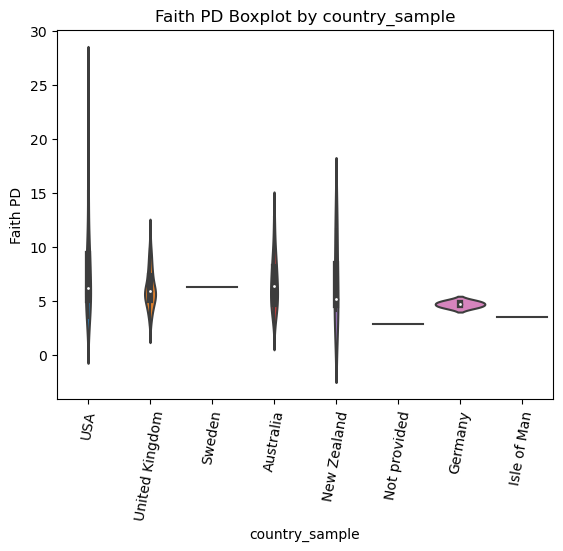

In [22]:
# make a boxplot with Faith PD on the y-axis and the selected 'type' on the x-axis (hint: look at the "by" parameter)
sns.violinplot(x=f'{types}_sample', y = dd.columns[0], data = dd)
plt.xlabel(f'{types}_sample')
plt.xticks(rotation = 80)
plt.ylabel('Faith PD')
plt.title(f'Faith PD Boxplot by {types}_sample')
plt.show()